In [13]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from model import BiGRU, CustomLoss, preprocess_data, CSVDataset, plot_heatmaps, preprocess_for_test, get_normalization_values, normalize_data, preprocess_common

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Point the save_folder to your predictions
save_folder = '/home/jonathan/Desktop/JARVIS-HybridNet/projects/May11/predictions/predictions3D/Predictions_3D_20230515-133741'
csv_file = save_folder + '/data3D.csv'
data = pd.read_csv(csv_file)

/tmp/ipykernel_838104/3370352594.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_file)


In [15]:
norm_values = get_normalization_values(data)
processed_data_common = preprocess_common(data)
processed_data = preprocess_data(processed_data_common, norm_values=norm_values)

# Set the model parameters
input_size = processed_data.shape[2]
hidden_size = 1024
num_layers = 1
dropout = 0.2
output_size = processed_data.shape[2]

# Initialize the model and loss function
model = BiGRU(input_size, hidden_size, num_layers, output_size, dropout=dropout)
criterion = CustomLoss()

# Set the learning rate
learning_rate = 0.001

# Initialize the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Set the number of epochs
epochs = 1000
batch_size = 32

if torch.cuda.is_available():
    device = torch.device("cuda")
    model.cuda()
else:
    device = torch.device("cpu")

model.train()

# Train the model
for epoch in range(epochs):
    processed_data = preprocess_data(processed_data_common, norm_values=norm_values, batch_size=batch_size)

    # Instantiate the custom dataset
    dataset = CSVDataset(processed_data)

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for batch_idx, (inputs, targets, confidence) in enumerate(dataloader):

        # Move tensors to the appropriate device (if using GPU)
        inputs, targets, confidence = inputs.to(device), targets.to(device), confidence.to(device)

        # Reset the gradients to zero
        optimizer.zero_grad()

        # Model output
        output = model(inputs)

        # Calculate loss
        loss = criterion(output, targets, confidence)

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss for the current batch
        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch: 1/1000, Loss: 0.6482569575309753
Epoch: 11/1000, Loss: 0.039296865463256836
Epoch: 21/1000, Loss: 0.023690737783908844
Epoch: 31/1000, Loss: 0.013612525537610054
Epoch: 41/1000, Loss: 0.006982692051678896
Epoch: 51/1000, Loss: 0.005412291269749403
Epoch: 61/1000, Loss: 0.004873382858932018
Epoch: 71/1000, Loss: 0.004516004119068384
Epoch: 81/1000, Loss: 0.0034840982407331467
Epoch: 91/1000, Loss: 0.003627161029726267
Epoch: 101/1000, Loss: 0.003078463952988386
Epoch: 111/1000, Loss: 0.0031170863658189774
Epoch: 121/1000, Loss: 0.0029072430916130543
Epoch: 131/1000, Loss: 0.0028052262496203184
Epoch: 141/1000, Loss: 0.0022295217495411634
Epoch: 151/1000, Loss: 0.002890546340495348
Epoch: 161/1000, Loss: 0.0025413373950868845
Epoch: 171/1000, Loss: 0.0022639483213424683
Epoch: 181/1000, Loss: 0.00206195842474699
Epoch: 191/1000, Loss: 0.0022515777964144945
Epoch: 201/1000, Loss: 0.002086627297103405
Epoch: 211/1000, Loss: 0.0020761233754456043
Epoch: 221/1000, Loss: 0.001859377953

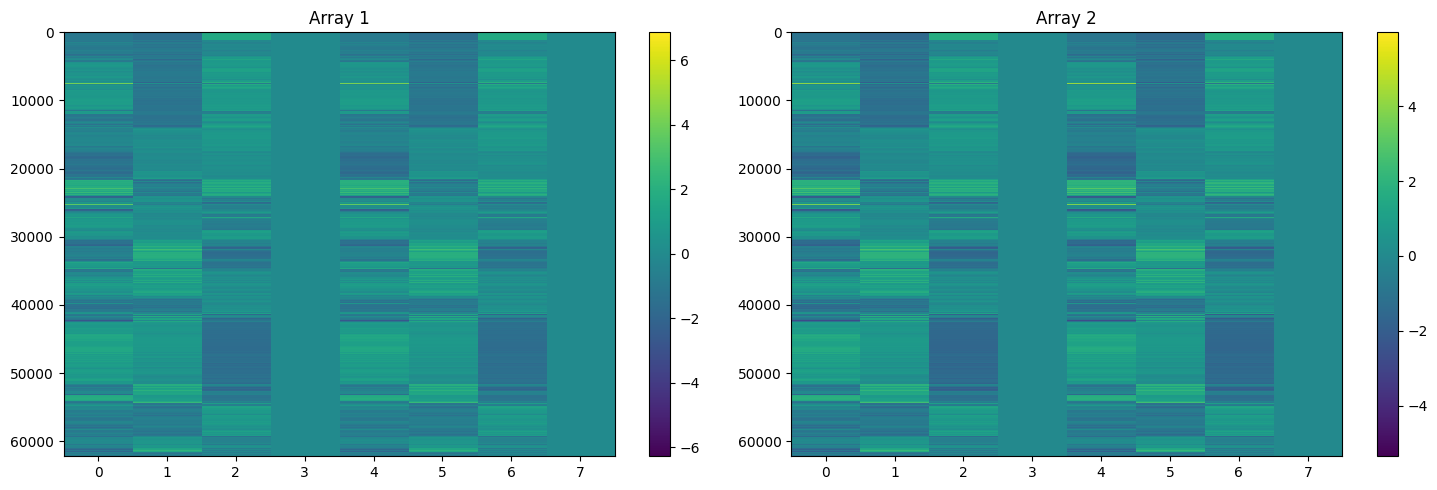

In [16]:
processed_data = preprocess_for_test(processed_data_common, norm_values=norm_values)
# Instantiate the custom dataset
dataset = CSVDataset(processed_data)
# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1)
for batch_idx, (inputs, targets, confidence) in enumerate(dataloader):
    inputs, targets, confidence = inputs.to(device), targets.to(device), confidence.to(device)
    model.eval()
    with torch.no_grad():
        output = model(inputs).cpu()
    plot_heatmaps(inputs[0,:,0:8].cpu(), output[0,:,0:8].detach().numpy())

In [17]:
data_aug = pd.DataFrame.copy(data)
# un-normalize
data_aug.loc[1:,:] = normalize_data(output.detach().numpy(), norm_values, forward=False)

# if you don't want to interpolate time points with no centerdetect
if False:
    nan_indices = data.isna().stack()[lambda x: x].index.tolist()
    for row, col in nan_indices:
        data_aug.at[row, col] = pd.NA

data_aug.to_csv(save_folder + '/data3D_smooth.csv', index=False)

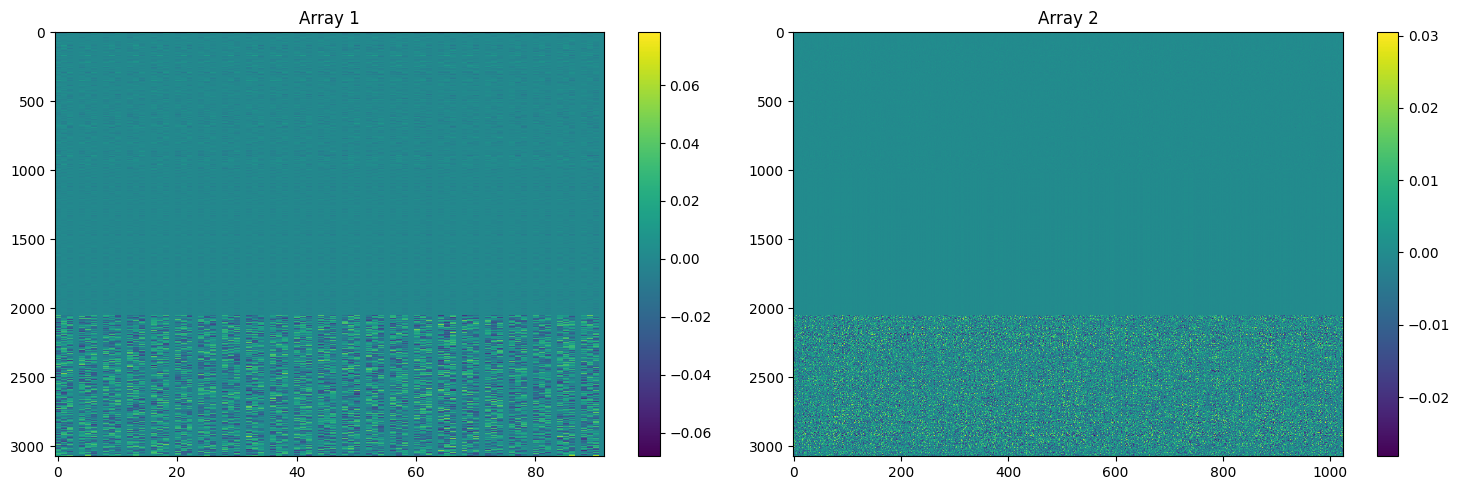

In [18]:
plot_heatmaps(model.gru.all_weights[0][0].cpu().detach().numpy(), model.gru.all_weights[0][1].cpu().detach().numpy())